<a href="https://colab.research.google.com/github/toan-ly/PEFT-LoRA-Basic/blob/main/LoRA_SentimentAnalysis_Llama3_2_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq --upgrade pip
!pip install -qq --upgrade peft transformers accelerate bitsandbytes datasets trl huggingface_hub evaluate

In [ ]:
from google.colab import userdata
from huggingface_hub import login

login(token=userdata.get('HF_TOKEN'))

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
import evaluate

from peft import PeftModel, PeftConfig, LoraConfig, TaskType, get_peft_model, get_peft_config
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset
from trl import SFTTrainer
import warnings
from transformers import DataCollatorWithPadding
from typing import Any, Dict, List


warnings.filterwarnings("ignore")

## Hyperparameters

In [ ]:
base_model_id = "meta-llama/Llama-3.2-1B-Instruct"
cache_dir = "./cache"

MAX_TRAIN_STEPS = 5_000
NUM_EVAL_STEPS = 500
MAX_TRAIN_SAMPLES = 20_000
MAX_EVAL_SAMPLES = 2_000

training_args = TrainingArguments(
    output_dir="./output",
    # num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=NUM_EVAL_STEPS,
    max_steps=MAX_TRAIN_STEPS,
    eval_steps=NUM_EVAL_STEPS,
    eval_strategy="steps",
    overwrite_output_dir=True,
    save_total_limit=2,
    report_to="none",
    push_to_hub=False,
    logging_first_step=True,
    remove_unused_columns=False,
)

## Load Base Model

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.bfloat16, cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True, cache_dir=cache_dir)

base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [ ]:
base_model = base_model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
if tokenizer.pad_token is None or tokenizer.pad_token_id is None:
    print("Pad token is not set. Setting it to EOS token.")
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
else:
    print(f'Pad token: {tokenizer.pad_token}')
    print(f'Pad token id: {tokenizer.pad_token_id}')

print(f'EOS token: {tokenizer.eos_token}')
print(f'EOS token id: {tokenizer.eos_token_id}')

Pad token is not set. Setting it to EOS token.
EOS token: <|eot_id|>
EOS token id: 128009


In [ ]:
if tokenizer.chat_template is None:
    tokenizer.chat_template = """{{- bos_token }}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}{%- set date_string = strftime_now("%d %b %Y") %}{%- else %}{%- set date_string = "26 Jul 2024" %}{%- endif %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{{- "Cutting Knowledge Date: December 2023\n" }}
{{- "Today Date: " + date_string + "\n\n" }}
{{- system_message }}
{{- "<|eot_id|>" }}

{%- for message in messages %}
    {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n'+ message['content'] | trim + '<|eot_id|>' }}
{%- endfor %}
{%- if add_generation_prompt %}
    {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' }}
{%- endif %}
"""

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello, how are you?"},
    {"role": "assistant", "content": "I'm just a computer program, but I'm here to help you!"},
]
print(tokenizer.apply_chat_template(conversation=messages, tokenize=False), end="\n\n")

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 16 Mar 2025

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

Hello, how are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I'm just a computer program, but I'm here to help you!<|eot_id|>



## Load and Apply LoRA

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

In [ ]:
peft_model = get_peft_model(base_model, peft_config)
peft_model.print_trainable_parameters()
peft_model

trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_feat

## Load Dataset and Format

In [ ]:
dataset = load_dataset("uitnlp/vietnamese_students_feedback", cache_dir=cache_dir)

for split in dataset:
    if split == "train":
        MAX_TRAIN_SAMPLES = min(MAX_TRAIN_SAMPLES, len(dataset[split]))
        dataset[split] = dataset[split].select(range(MAX_TRAIN_SAMPLES))
    else:
        MAX_EVAL_SAMPLES = min(MAX_EVAL_SAMPLES, len(dataset[split]))
        dataset[split] = dataset[split].select(range(MAX_EVAL_SAMPLES))
    print(f"{split}: {len(dataset[split])}")

train: 11426
validation: 1583
test: 1583


In [ ]:
print(f'A sample from the train set: {dataset["train"][0]}')

A sample from the train set: {'sentence': 'slide giáo trình đầy đủ .', 'sentiment': 2, 'topic': 1}


In [ ]:
label_set = set([item["sentiment"] for split in dataset for item in dataset[split]])
label_set

{0, 1, 2}

In [ ]:
all_labels = dataset['train'].features['sentiment'].names
print(f'There are {len(all_labels)} labels in the dataset, including {all_labels}')

label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for i, label in enumerate(all_labels)}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

There are 3 labels in the dataset, including ['negative', 'neutral', 'positive']
label2id: {'negative': 0, 'neutral': 1, 'positive': 2}
id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [ ]:
USER_PROMPT_TEMPLATE = """Predict the sentiment of the following input sentence.
The response must begin with "Sentiment: ", followed by one of these keywords: "positive", "negative", or "neutral", to reflect the sentiment of the input sentence.

Sentence: {input}"""

def tokenize_function(examples):
    results = {
        "input_ids": [],
        "labels": [],
        "attention_mask": [],
    }

    for i in range(len(examples['sentence'])):
        cur_input = examples['sentence'][i]
        cur_output_id = examples['sentiment'][i]

        cur_prompt = USER_PROMPT_TEMPLATE.format(input=cur_input)
        cur_output = id2label[cur_output_id]

        input_messages = [
            {"role": "system", "content": "You are a helpful assistant. You must fulfill the user request."},
            {"role": "user", "content": cur_prompt},
        ]
        input_output_messages = input_messages + [{"role": "assistant", "content": f"Sentiment: {cur_output}"}]

        input_prompt_tokenized = tokenizer.apply_chat_template(conversation=input_messages, return_tensors="pt", add_generation_prompt=True)[0]
        input_output_prompt_tokenized = tokenizer.apply_chat_template(conversation=input_output_messages, return_tensors="pt")[0]

        # print(f'Input prompt tokenized: {input_prompt_tokenized}')
        # print(f'Input/Output prompt tokenized: {input_output_prompt_tokenized}')

        input_ids = input_output_prompt_tokenized
        label_ids = torch.cat([
            torch.full_like(input_prompt_tokenized, fill_value=-100),
            input_output_prompt_tokenized[len(input_prompt_tokenized):]
        ])

        # print(f'Input ids: {input_ids}')
        # print(f'Label ids: {label_ids}')
        # print(f'Decoded label ids: {tokenizer.decode(np.where(label_ids!=-100, label_ids, tokenizer.pad_token_id), skip_special_tokens=True)}')
        assert len(input_ids) == len(label_ids)


        results["input_ids"].append(input_ids)
        results["labels"].append(label_ids)
        results['attention_mask'].append(torch.ones_like(input_ids))

    return results

col_names = dataset['train'].column_names
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=col_names,
    num_proc=os.cpu_count(),
)
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 1583
    })
})

In [ ]:
print(tokenized_dataset['train'][0])
print(tokenizer.decode(tokenized_dataset['train'][0]['input_ids'], skip_special_tokens=False))

{'input_ids': [128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696, 25, 6790, 220, 2366, 18, 198, 15724, 2696, 25, 220, 845, 2947, 220, 2366, 20, 271, 2675, 527, 264, 11190, 18328, 13, 1472, 2011, 21054, 279, 1217, 1715, 13, 128009, 128006, 882, 128007, 271, 54644, 279, 27065, 315, 279, 2768, 1988, 11914, 627, 791, 2077, 2011, 3240, 449, 330, 32458, 3904, 25, 3755, 8272, 555, 832, 315, 1521, 21513, 25, 330, 31587, 498, 330, 43324, 498, 477, 330, 60668, 498, 311, 8881, 279, 27065, 315, 279, 1988, 11914, 382, 85664, 25, 15332, 104300, 101291, 107114, 104602, 662, 128009, 128006, 78191, 128007, 271, 32458, 3904, 25, 6928, 128009], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

## Custom data collator

In [ ]:
class RightPaddingDataCollator(DataCollatorWithPadding):
    """The default data collator pads only inputs, not including the labels."""

    def __init__(self, tokenizer, max_length: int = 1024):
        super().__init__(tokenizer, max_length=max_length)

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_ids, labels, attention_mask = [], [], []
        max_batch_len = max(len(f["input_ids"]) for f in features)

        for sample in features:
            # Convert to torch tensors
            cur_input_ids = torch.tensor(sample["input_ids"], dtype=torch.long)
            cur_labels = torch.tensor(sample["labels"], dtype=torch.long)
            cur_attention_mask = torch.ones_like(cur_input_ids)

            # Next, we pad the inputs and labels to the maximum length within the batch
            pad_token_id = self.tokenizer.pad_token_id
            padding_length = max_batch_len - len(cur_input_ids)
            cur_input_ids = torch.cat([cur_input_ids, torch.full((padding_length,), fill_value=pad_token_id, dtype=torch.long)])
            cur_labels = torch.cat([cur_labels, torch.full((padding_length,), fill_value=-100, dtype=torch.long)])
            cur_attention_mask = torch.cat([cur_attention_mask, torch.zeros((padding_length,), dtype=torch.long)])

            # Truncate the inputs and labels to the maximum length
            cur_input_ids = cur_input_ids[:max_batch_len]
            cur_labels = cur_labels[:max_batch_len]
            cur_attention_mask = cur_attention_mask[:max_batch_len]

            # Append to the return lists
            input_ids.append(cur_input_ids)
            labels.append(cur_labels)
            attention_mask.append(cur_attention_mask)

        # Return formatted batch.
        return {
            "input_ids": torch.stack(input_ids),
            "labels": torch.stack(labels),
            "attention_mask": torch.stack(attention_mask)
        }


data_collator = RightPaddingDataCollator(tokenizer)

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")


def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1)


def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    idx = 0
    for i in range(len(labels[0])):
        if labels[0][i] == -100:
            idx = i
        else:
            break
    # Slice the labels and preds to remove the prompt tokens
    preds = preds[:, idx:]

    # Replace -100 in the preds as we can't decode them
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)

    processed_preds = []
    for pred in preds:
        end_pred_idx = np.where(pred == tokenizer.eos_token_id)[0]
        if len(end_pred_idx) > 0:
            end_pred_idx = end_pred_idx[0]
            processed_preds.append(pred[:end_pred_idx])
        else:
            processed_preds.append(pred)

    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(processed_preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Convert the decoded predictions and labels to label ids
    # int_preds = [label2id.get(p, -1) for p in decoded_preds]
    # int_labels = [label2id[label] for label in decoded_labels]
    int_preds, int_labels = [], []
    for p, l in zip(decoded_preds, decoded_labels):
        l = l.split(":")[-1].strip()
        cur_label_id = label2id[l]
        int_labels.append(cur_label_id)
        try:
            p = p.split(":")[-1].strip()
            cur_pred_id = label2id[p]
        except Exception as e:
            cur_pred_id = (cur_label_id + 1) % len(label2id)
        int_preds.append(cur_pred_id)

    # results = f1_metric.compute(predictions=[0, -1, -1], references=[0, 1, 2], average="macro")
    accuracy_results = accuracy_metric.compute(predictions=int_preds, references=int_labels)
    f1_results = f1_metric.compute(predictions=int_preds, references=int_labels, average="macro")
    precision_results = precision_metric.compute(predictions=int_preds, references=int_labels, average="macro")
    recall_results = recall_metric.compute(predictions=int_preds, references=int_labels, average="macro")

    return {
        **accuracy_results,
        **f1_results,
        **precision_results,
        **recall_results
    }

## Train the Model

In [ ]:
trainer = SFTTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    data_collator=data_collator,
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.062800,0.053733,0.480733,0.399065,0.468231,0.417304
1000,0.069600,0.058507,0.461150,0.386854,0.461126,0.407269
1500,0.009700,0.046875,0.497157,0.418743,0.480909,0.461639
2000,0.034500,0.053216,0.551485,0.452542,0.501648,0.483167
2500,0.044200,0.049073,0.425142,0.364655,0.443869,0.397925
3000,0.044000,0.040853,0.409981,0.360517,0.445127,0.420147
3500,0.063400,0.049783,0.409349,0.351577,0.433988,0.378447
4000,0.052400,0.044076,0.406822,0.355399,0.437676,0.405386
4500,0.011100,0.045573,0.409981,0.355073,0.435319,0.395176
5000,0.059900,0.045517,0.412508,0.356974,0.437250,0.397067


TrainOutput(global_step=5000, training_loss=0.047776339937374, metrics={'train_runtime': 721.3888, 'train_samples_per_second': 27.724, 'train_steps_per_second': 6.931, 'total_flos': 1.477983256915968e+16, 'train_loss': 0.047776339937374})

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_stats = pd.DataFrame(trainer.state.log_history)
train_stats = train_stats[:-1]
train_stats

,loss,grad_norm,learning_rate,mean_token_accuracy,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,eval_mean_token_accuracy,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.1787,8.094889,4.999000e-05,0.900000,0.000350,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1104,0.692717,4.990000e-05,0.972222,0.003500,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0467,0.058950,4.980000e-05,0.990000,0.007000,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.1542,9.387649,4.970000e-05,0.955000,0.010501,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0976,0.174217,4.960000e-05,0.980000,0.014001,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.0447,7.487259,2.000000e-07,0.985000,1.743087,4980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,0.0270,0.119046,1.000000e-07,0.995000,1.746587,4990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,0.0599,2.121934,0.000000e+00,0.990000,1.750088,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510,NaN,NaN,NaN,NaN,1.750088,5000,0.045517,0.412508,0.356974,0.43725,0.397067,18.7604,84.38,10.554,0.98824,NaN,NaN,NaN,NaN,NaN


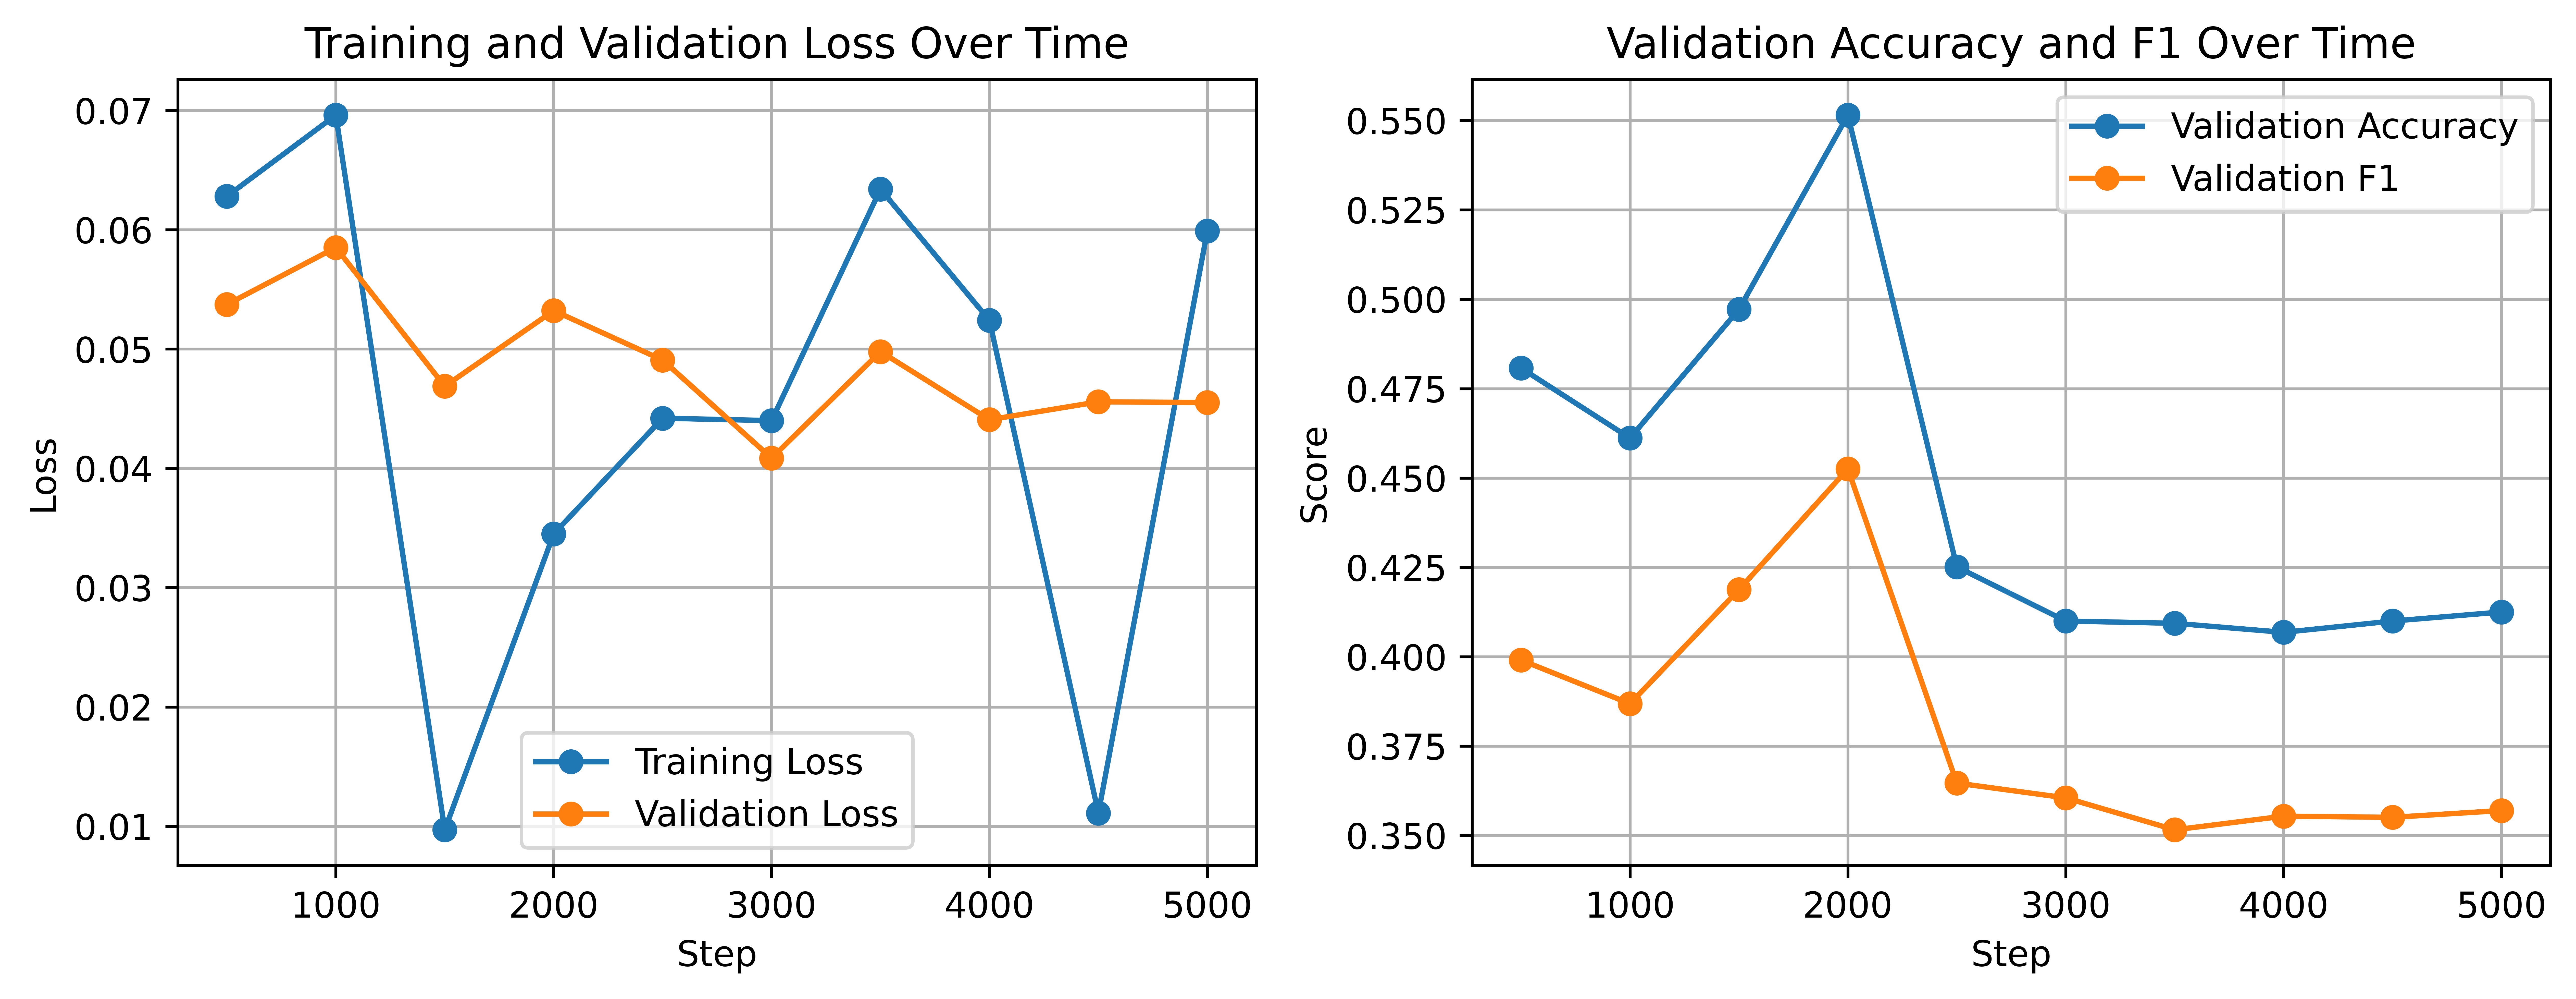

In [ ]:
train_df = train_stats[train_stats['step'] % 500 == 0].copy()
train_df = train_df[train_df['loss'].notna()]
eval_df = train_stats[train_stats['step'] % 500 == 0].copy()
eval_df = eval_df[eval_df['eval_loss'].notna()]

# filtered_df = train_stats[train_stats['step'] % 500 == 0].copy()
# filtered_df = filtered_df.fillna(method='ffill')
train_step = train_df['step'].to_numpy()
train_loss = train_df['loss'].to_numpy()
evval_loss = eval_df['eval_loss'].to_numpy()
eval_accuracy = eval_df['eval_accuracy'].to_numpy()
eval_f1 = eval_df['eval_f1'].to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=1000)

# plot 1 is loss and eval_loss
ax[0].plot(train_step, train_loss, label='Training Loss', marker='o')
ax[0].plot(train_step, evval_loss, label='Validation Loss', marker='o')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss Over Time')
ax[0].legend()
ax[0].grid(True)

# plot 2 is eval_accuracy and eval_f1
ax[1].plot(train_step, eval_accuracy, label='Validation Accuracy', marker='o')
ax[1].plot(train_step, eval_f1, label='Validation F1', marker='o')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Score')
ax[1].set_title('Validation Accuracy and F1 Over Time')
ax[1].legend()
ax[1].grid(True)

# save figure to train_results.pdf
plt.savefig('train_results.pdf')

In [ ]:
# Evaluate the model on the test set
trainer.evaluate(tokenized_dataset['test'])

## Inference Pipeline

In [ ]:
def inference(model, tokenizer, input_sentence):
    tokenizer.pad_token_id = tokenizer.eos_token_id

    user_prompt = USER_PROMPT_TEMPLATE.format(input=input_sentence)
    messages = [
        {"role": "system", "content": "You are a helpful assistant. You must fulfill the user request."},
        {"role": "user", "content": user_prompt},
    ]
    input_prompt = tokenizer.apply_chat_template(conversation=messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer(input_prompt, return_tensors="pt", add_special_tokens=False)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    output_ids = model.generate(**inputs, max_new_tokens=16, pad_token_id=tokenizer.eos_token_id)
    output_ids = output_ids[:, inputs['input_ids'][0].shape[-1]:output_ids.shape[-1]]
    results = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    return results[0]

def batch_inference(model, tokenizer, input_sentences):
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

    user_prompts = [USER_PROMPT_TEMPLATE.format(input=input_sentence) for input_sentence in input_sentences]
    messages_list = [
        [
            {"role": "system", "content": "You are a helpful assistant. You must fulfill the user request."},
            {"role": "user", "content": user_prompt},
        ]
        for user_prompt in user_prompts
    ]
    input_prompts = [tokenizer.apply_chat_template(conversation=messages, add_generation_prompt=True, tokenize=False) for messages in messages_list]

    inputs = tokenizer(input_prompts, return_tensors="pt", padding=True, add_special_tokens=False)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    output_ids = model.generate(**inputs, max_new_tokens=16, pad_token_id=tokenizer.eos_token_id)
    output_ids = output_ids[:, inputs['input_ids'][0].shape[-1]:output_ids.shape[-1]]
    results = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    return results

In [ ]:
inference(peft_model, tokenizer, "The weather is nice today."), inference(peft_model, tokenizer, "I love this product.")

('Sentiment: positive', 'Sentiment: positive')

In [ ]:
batch_inference(peft_model, tokenizer, ["I love this product.", "I hate this product. It is because the quality is extremely bad."])

['Sentiment: positive', 'Sentiment: negative']

In [ ]:
batch_inference(peft_model, tokenizer, ["Môn học này quá khó để học", "Thầy dạy hay, dễ hiểu"])

['Sentiment: negative', 'Sentiment: positive']

## Evaluate the models using zero-, one-, and few-shot learning

In [ ]:
def evaluate_zero_shot(model, tokenizer, eval_dataset, batch_size=8):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []

    print_example = True

    # Process dataset in batches
    for i in range(0, len(eval_dataset), batch_size):
        batch = eval_dataset[i:i + batch_size]

        # Get predictions for batch
        predictions = batch_inference(model, tokenizer, batch['sentence'])
        if print_example:
            print_example = False
            for sentence, prediction, label in zip(batch['sentence'], predictions, batch['sentiment']):
                print(f"Sentence: {sentence}")
                print(f"Model Output: {prediction}")
                print(f"Label: {id2label[label]}")
                print()

        # Convert text predictions to label ids
        pred_ids = []
        true_labels = batch['sentiment']

        for p, l in zip(predictions, true_labels):
            try:
                label_id = l
                p = p.split(":")[-1].strip()
                pred_id = label2id[p]
            except Exception as e:
                pred_id = (l + 1) % len(label2id) # Choose the next label, ensure the prediction is marked as incorrect
            pred_ids.append(pred_id)

        all_predictions.extend(pred_ids)
        all_labels.extend(true_labels)

    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_metric.compute(predictions=all_predictions, references=all_labels),
        'f1': f1_metric.compute(predictions=all_predictions, references=all_labels, average='macro'),
        'precision': precision_metric.compute(predictions=all_predictions, references=all_labels, average='macro'),
        'recall': recall_metric.compute(predictions=all_predictions, references=all_labels, average='macro')
    }

    # Combine all metrics into single dict
    results = {}
    for metric_name, metric_dict in metrics.items():
        results.update(metric_dict)

    return results

In [ ]:
# Example usage
zero_shot_results = evaluate_zero_shot(
    model=peft_model,
    tokenizer=tokenizer,
    eval_dataset=dataset['test'],
    batch_size=8
)

print("Zero-shot evaluation results:")
for metric_name, value in zero_shot_results.items():
    print(f"{metric_name}: {value:.4f}")

Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: negative
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: neutral
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive

Zero-shot evaluation results:
accuracy: 0.9292
f1: 0.8136
precision: 0.8701
recall: 0.7837


In [ ]:
USER_FEWSHOT_PROMPT_TEMPLATE = """Predict the sentiment of the following input sentence.
The response must begin with "Sentiment: ", followed by one of these keywords: "positive", "negative", or "neutral", to reflect the sentiment of the input sentence.

Here are a few examples:

{few_shot_examples}

Sentence: {input}"""

def evaluate_few_shot(model, tokenizer, eval_dataset, few_shot_examples, batch_size=8, print_example=False):
    model.eval()
    all_predictions = []
    all_labels = []

    # Format the few-shot examples for the prompt
    formatted_few_shot_examples = ""
    for i, example in enumerate(few_shot_examples):
        formatted_few_shot_examples += f"Sentence: {example['sentence']}\nSentiment: {id2label[example['sentiment']]}\n"
        if i < len(few_shot_examples) - 1:
            formatted_few_shot_examples += "\n"


    for i in range(0, len(eval_dataset), batch_size):
        batch = eval_dataset[i:i + batch_size]

        # Replace USER_PROMPT_TEMPLATE with USER_FEWSHOT_PROMPT_TEMPLATE
        user_prompts = [USER_FEWSHOT_PROMPT_TEMPLATE.format(input=sentence, few_shot_examples=formatted_few_shot_examples) for sentence in batch['sentence']]

        messages_list = [
            [
                {"role": "system", "content": "You are a helpful assistant. You must fulfill the user request."},
                {"role": "user", "content": user_prompt},
            ]
            for user_prompt in user_prompts
        ]

        input_prompts = [tokenizer.apply_chat_template(conversation=messages, add_generation_prompt=True, tokenize=False) for messages in messages_list]
        inputs = tokenizer(input_prompts, return_tensors="pt", padding=True, add_special_tokens=False)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        output_ids = model.generate(**inputs, max_new_tokens=16, pad_token_id=tokenizer.eos_token_id)
        output_ids = output_ids[:, inputs['input_ids'][0].shape[-1]:output_ids.shape[-1]]
        predictions = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        if print_example:
            print_example = False
            print(f"### Prompt:\n{user_prompts[0]}")
            print(f"### Model Output:\n{predictions[0]}")
            print(f"### Label:\n{id2label[batch['sentiment'][0]]}")
            print()

        pred_ids = []
        true_labels = batch['sentiment']
        for p, l in zip(predictions, true_labels):
            try:
                label_id = l
                p = p.split(":")[-1].strip()
                pred_id = label2id[p]
            except Exception as e:
                pred_id = (l + 1) % len(label2id)
            pred_ids.append(pred_id)

        all_predictions.extend(pred_ids)
        all_labels.extend(true_labels)

    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")

    metrics = {
        'accuracy': accuracy_metric.compute(predictions=all_predictions, references=all_labels),
        'f1': f1_metric.compute(predictions=all_predictions, references=all_labels, average='macro'),
        'precision': precision_metric.compute(predictions=all_predictions, references=all_labels, average='macro'),
        'recall': recall_metric.compute(predictions=all_predictions, references=all_labels, average='macro')
    }

    results = {}
    for metric_name, metric_dict in metrics.items():
        results.update(metric_dict)

    return results

In [ ]:
# Pick a list of shot from the train set
shuffled_train_dataset = dataset['train'].shuffle()
sampled_few_shot_examples = list(shuffled_train_dataset.select(range(10)))
few_shot_result_df = pd.DataFrame(columns=['n_shots', 'accuracy', 'f1', 'precision', 'recall'])

n_shots = [1, 2, 4, 8]
for n in n_shots:
    few_shot_examples = sampled_few_shot_examples[:n]
    few_shot_results = evaluate_few_shot(
        model=base_model,
        tokenizer=tokenizer,
        eval_dataset=dataset['test'],
        few_shot_examples=few_shot_examples,
        batch_size=16,
        print_example=True,
    )
    print(f"*** Few-shot evaluation results with {n} shots:")
    for metric_name, value in few_shot_results.items():
        print(f"* {metric_name}: {value:.4f}")
    print()
    few_shot_result_df.loc[len(few_shot_result_df)] = [n, few_shot_results['accuracy'], few_shot_results['f1'], few_shot_results['precision'], few_shot_results['recall']]

few_shot_result_df = few_shot_result_df.round(4).astype(str)
few_shot_result_df['accuracy'] = few_shot_result_df['accuracy'].apply(lambda x: f"{float(x):.4f}")
few_shot_result_df['f1'] = few_shot_result_df['f1'].apply(lambda x: f"{float(x):.4f}")
few_shot_result_df['precision'] = few_shot_result_df['precision'].apply(lambda x: f"{float(x):.4f}")
few_shot_result_df['recall'] = few_shot_result_df['recall'].apply(lambda x: f"{float(x):.4f}")
few_shot_result_df['n_shots'] = few_shot_result_df['n_shots'].apply(lambda x: int(float(x)))
few_shot_result_df

### Prompt:
Predict the sentiment of the following input sentence.
The response must begin with "Sentiment: ", followed by one of these keywords: "positive", "negative", or "neutral", to reflect the sentiment of the input sentence.

Here are a few examples:

Sentence: giảng viên tập trung quá nhiều vào điện thoại trong giờ lên lớp .
Sentiment: negative


Sentence: nói tiếng anh lưu loát .
### Model Output:
Sentiment: positive
### Label:
positive

*** Few-shot evaluation results with 1 shots:
* accuracy: 0.6999
* f1: 0.4825
* precision: 0.6933
* recall: 0.5085

### Prompt:
Predict the sentiment of the following input sentence.
The response must begin with "Sentiment: ", followed by one of these keywords: "positive", "negative", or "neutral", to reflect the sentiment of the input sentence.

Here are a few examples:

Sentence: giảng viên tập trung quá nhiều vào điện thoại trong giờ lên lớp .
Sentiment: negative

Sentence: giảng viên tận tâm , nhiệt tình đới với sinh viên .
Sentiment: posi

,n_shots,accuracy,f1,precision,recall
0,1.0,0.6999,0.4825,0.6933,0.5085
1,2.0,0.7795,0.5412,0.7117,0.5604
2,4.0,0.8743,0.6346,0.8628,0.6362
3,8.0,0.8042,0.5867,0.8922,0.591


In [ ]:
few_shot_result_df['accuracy'] = few_shot_result_df['accuracy'].apply(lambda x: f"{float(x):.4f}")
few_shot_result_df['f1'] = few_shot_result_df['f1'].apply(lambda x: f"{float(x):.4f}")
few_shot_result_df['precision'] = few_shot_result_df['precision'].apply(lambda x: f"{float(x):.4f}")
few_shot_result_df['recall'] = few_shot_result_df['recall'].apply(lambda x: f"{float(x):.4f}")
few_shot_result_df['n_shots'] = few_shot_result_df['n_shots'].apply(lambda x: int(float(x)))
few_shot_result_df

,n_shots,accuracy,f1,precision,recall
0,1,0.6999,0.4825,0.6933,0.5085
1,2,0.7795,0.5412,0.7117,0.5604
2,4,0.8743,0.6346,0.8628,0.6362
3,8,0.8042,0.5867,0.8922,0.5910


In [ ]:
# save few_shot_result_df to latex
few_shot_result_df.to_latex('few_shot_result_df.tex', index=False)

## Changing rank of LoRA

In [ ]:
def train_lora(base_model, tokenizer, training_args, lora_rank, dataset):
    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM, inference_mode=False, r=lora_rank, lora_alpha=32, lora_dropout=0.1
    )
    cur_peft_model = get_peft_model(base_model, peft_config)
    cur_peft_model.print_trainable_parameters()

    trainer = SFTTrainer(
        model=cur_peft_model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        compute_metrics=compute_metrics,
        processing_class=tokenizer,
        data_collator=data_collator,
    )
    trainer.train()
    return cur_peft_model


In [ ]:
ranks = [1, 2, 4, 8, 16, 32, 64, 128]
# ranks = [1, 2]
rank_results = pd.DataFrame(columns=['rank', 'accuracy', 'f1', 'precision', 'recall'])
for rank in ranks:
    print(f'*** Train with rank {rank}')
    cur_trained_model = train_lora(base_model, tokenizer, training_args, rank, tokenized_dataset)
    cur_results = evaluate_zero_shot(
        model=cur_trained_model,
        tokenizer=tokenizer,
        eval_dataset=dataset['test'],
        batch_size=8
    )

    # add current results to rank_results
    rank_results.loc[len(rank_results)] = [rank, cur_results['accuracy'], cur_results['f1'], cur_results['precision'], cur_results['recall']]
rank_results

*** Train with rank 1
trainable params: 106,496 || all params: 1,235,920,896 || trainable%: 0.0086


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.079200,0.059666,0.411244,0.349959,0.435880,0.363668
1000,0.063700,0.064814,0.482628,0.399369,0.470025,0.414805
1500,0.005000,0.055298,0.462413,0.395301,0.467591,0.440903
2000,0.029400,0.062296,0.459255,0.385710,0.458551,0.410590
2500,0.074400,0.064693,0.408086,0.351749,0.435624,0.381653
3000,0.057500,0.052504,0.411244,0.360446,0.443274,0.416882
3500,0.095400,0.065847,0.407454,0.349698,0.434288,0.372994
4000,0.055500,0.054083,0.411244,0.353896,0.436806,0.384017
4500,0.010300,0.056628,0.412508,0.354775,0.436959,0.384787
5000,0.072300,0.056926,0.408718,0.351196,0.433948,0.377915


Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: positive
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive

*** Train with rank 2
trainable params: 212,992 || all params: 1,236,027,392 || trainable%: 0.0172


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.080500,0.062422,0.404296,0.341734,0.430767,0.342270
1000,0.079700,0.059272,0.415666,0.352881,0.437619,0.366978
1500,0.008600,0.050447,0.457359,0.388035,0.458520,0.425427
2000,0.031100,0.059556,0.461781,0.387904,0.458709,0.416809
2500,0.067000,0.052407,0.409981,0.353896,0.437344,0.387283
3000,0.059800,0.047472,0.406822,0.354951,0.439555,0.401468
3500,0.081100,0.054613,0.409349,0.351789,0.435418,0.378506
4000,0.058300,0.049121,0.408718,0.353339,0.434152,0.390313
4500,0.007500,0.049823,0.416298,0.359148,0.440224,0.395752
5000,0.066000,0.050253,0.418825,0.360901,0.441236,0.397584


Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: neutral
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive

*** Train with rank 4
trainable params: 425,984 || all params: 1,236,240,384 || trainable%: 0.0345


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.066200,0.056274,0.531270,0.433539,0.491612,0.453719
1000,0.070400,0.059391,0.545799,0.445427,0.500074,0.467337
1500,0.008500,0.049683,0.546431,0.453508,0.502074,0.496581
2000,0.040900,0.054914,0.600126,0.489449,0.527949,0.525705
2500,0.062900,0.050986,0.497789,0.419265,0.483300,0.462700
3000,0.048000,0.042219,0.457359,0.396099,0.470254,0.458351
3500,0.074300,0.053806,0.457991,0.384156,0.459264,0.405551
4000,0.055400,0.046741,0.473784,0.403941,0.472501,0.453801
4500,0.008100,0.048134,0.470625,0.397554,0.465626,0.434945
5000,0.066000,0.047413,0.475047,0.401804,0.470048,0.442407


Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: negative
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: neutral
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive



No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


*** Train with rank 8
trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.059800,0.054287,0.522426,0.427420,0.485816,0.447041
1000,0.066700,0.058229,0.505370,0.417375,0.482531,0.439191
1500,0.009800,0.048316,0.553380,0.461090,0.509146,0.509851
2000,0.028700,0.052630,0.590651,0.479956,0.520179,0.510661
2500,0.051100,0.048823,0.500948,0.418820,0.480441,0.457053
3000,0.041000,0.041786,0.437145,0.382123,0.460761,0.447902
3500,0.068200,0.049769,0.445357,0.376029,0.452423,0.400658
4000,0.052500,0.045130,0.451042,0.386379,0.458509,0.433332
4500,0.007800,0.046592,0.454833,0.387977,0.458114,0.431899
5000,0.059800,0.045949,0.457359,0.389814,0.459269,0.433614


Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: negative
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: neutral
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive

*** Train with rank 16
trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.064800,0.051539,0.491472,0.406256,0.472033,0.424989
1000,0.060200,0.053901,0.486418,0.404209,0.471598,0.425242
1500,0.011100,0.045210,0.535692,0.447330,0.500248,0.492871
2000,0.029900,0.049757,0.519267,0.428918,0.487568,0.457016
2500,0.048400,0.046007,0.436513,0.373631,0.451705,0.410647
3000,0.043500,0.039547,0.418825,0.367093,0.450352,0.426591
3500,0.064500,0.046734,0.416298,0.354680,0.436340,0.375520
4000,0.050900,0.042856,0.420720,0.365300,0.443911,0.415670
4500,0.009100,0.044576,0.425142,0.364830,0.440581,0.402078
5000,0.057900,0.043929,0.432723,0.370315,0.445653,0.407869


Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: negative
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: neutral
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive

*** Train with rank 32
trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.054700,0.050805,0.538219,0.437463,0.494033,0.454005
1000,0.056700,0.050773,0.485155,0.403326,0.470537,0.424237
1500,0.012600,0.043546,0.528743,0.442173,0.495581,0.488023
2000,0.028400,0.046781,0.509160,0.421839,0.482561,0.449804
2500,0.047600,0.044686,0.419457,0.359905,0.441962,0.389929
3000,0.039100,0.038850,0.409981,0.362031,0.446679,0.428393
3500,0.061300,0.045242,0.412508,0.351384,0.434131,0.368413
4000,0.046600,0.040737,0.413771,0.358611,0.438055,0.402106
4500,0.010100,0.042362,0.413771,0.355969,0.434520,0.389650
5000,0.053900,0.041354,0.413771,0.356049,0.435026,0.389650


Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: negative
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: neutral
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive

*** Train with rank 64
trainable params: 6,815,744 || all params: 1,242,630,144 || trainable%: 0.5485


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.052100,0.050273,0.562855,0.453079,0.503596,0.466941
1000,0.052100,0.048468,0.514845,0.423648,0.483302,0.445402
1500,0.013300,0.042778,0.565382,0.468527,0.514232,0.513860
2000,0.025100,0.044527,0.533797,0.438970,0.493011,0.467010
2500,0.045700,0.042231,0.427037,0.364450,0.445546,0.391392
3000,0.041700,0.037737,0.418825,0.367822,0.450685,0.430684
3500,0.058700,0.043264,0.416930,0.355037,0.436148,0.375993
4000,0.040500,0.039500,0.413771,0.357746,0.437431,0.398189
4500,0.009300,0.041082,0.413771,0.355723,0.433741,0.389943
5000,0.048100,0.039988,0.418193,0.359055,0.437219,0.393194


Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: neutral
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive

*** Train with rank 128
trainable params: 13,631,488 || all params: 1,249,445,888 || trainable%: 1.0910


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.049300,0.050510,0.535692,0.435454,0.492348,0.452466
1000,0.047700,0.047195,0.496526,0.411031,0.475435,0.432454
1500,0.016100,0.041953,0.524321,0.436826,0.491756,0.476702
2000,0.026100,0.042237,0.526848,0.434588,0.492068,0.461926
2500,0.044800,0.040555,0.439672,0.371095,0.448369,0.392427
3000,0.040200,0.037502,0.422615,0.370663,0.453540,0.433638
3500,0.059900,0.041033,0.426406,0.362551,0.441380,0.386943
4000,0.039100,0.038114,0.437776,0.374760,0.448339,0.415568
4500,0.011500,0.039097,0.427669,0.366515,0.441299,0.404028
5000,0.045600,0.038424,0.428301,0.367135,0.443028,0.404618


Sentence: nói tiếng anh lưu loát .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên rất vui tính .
Model Output: Sentiment: positive
Label: positive

Sentence: cô max có tâm .
Model Output: Sentiment: positive
Label: positive

Sentence: giảng bài thu hút , dí dỏm .
Model Output: Sentiment: positive
Label: positive

Sentence: giáo viên không giảng dạy kiến thức , hướng dẫn thực hành trong quá trình học .
Model Output: Sentiment: negative
Label: negative

Sentence: thầy dạy nhiệt tình và tâm huyết .
Model Output: Sentiment: positive
Label: positive

Sentence: tính điểm thi đua các nhóm .
Model Output: Sentiment: neutral
Label: positive

Sentence: thầy nhiệt tình giảng lại cho học sinh .
Model Output: Sentiment: positive
Label: positive



In [ ]:
rank_results['accuracy'] = rank_results['accuracy'].apply(lambda x: f"{float(x):.4f}")
rank_results['f1'] = rank_results['f1'].apply(lambda x: f"{float(x):.4f}")
rank_results['precision'] = rank_results['precision'].apply(lambda x: f"{float(x):.4f}")
rank_results['recall'] = rank_results['recall'].apply(lambda x: f"{float(x):.4f}")
rank_results['rank'] = rank_results['rank'].apply(lambda x: int(float(x)))
rank_results.to_latex('rank_results.tex', index=False)
rank_results

,rank,accuracy,f1,precision,recall
0,1,0.9261,0.7957,0.8844,0.7606
1,2,0.9299,0.8094,0.8766,0.7772
2,4,0.9292,0.8102,0.8815,0.7767
3,8,0.9267,0.8015,0.8628,0.7715
4,16,0.9299,0.8163,0.8799,0.7842
5,32,0.9274,0.8077,0.8625,0.7788
6,64,0.9305,0.8168,0.8803,0.7846
7,128,0.9280,0.8137,0.8623,0.7862
